Import dependencies - this can be installed by running 'pip install -r requirements.txt' from the root of the repo

In [1]:

from pathlib import Path
import os, json, glob
from collections import defaultdict
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from yellowbrick.classifier import ConfusionMatrix

The datasets are contained in the /data folder off the root of the repository

In [2]:
PATH = (Path(os.getcwd()) / "../data").resolve()

Helper functions to read dataset into a pandas dataframe from the seperate files

In [3]:
def read_file(filename:str):
    """
    Each file should have the same structure

    epoch, timestamp and elapsed columns reprenting sample time and 3 data channels
    """

    # read raw file
    df=pd.read_csv(filename)

    # drop unused columns
    df = df.drop(["epoc (ms)","elapsed (s)"],axis=1)

    # convert timestamp to datetime
    df["timestamp"] = pd.to_datetime(df["timestamp (+1000)"], format='%Y-%m-%dT%H.%M.%S.%f')

    df = df.drop(["timestamp (+1000)"],axis=1)

    # index on timestamp
    df = df.set_index("timestamp")

    return df

def interpolate(df, new_index, limit=1):
    """
    Use zero order hold interpolation
    """
    return df.reindex(df.index | new_index).fillna(method='ffill', limit=limit).loc[new_index]

def read_sensor_data(
    path:str,                  # location of experiments
    experiment:str,            # experiment folder
    device:str,                # name of device (A, W)):
    freq="5L",                 # "5L" = 5ms = 200Hz
    ) ->  pd.DataFrame:         
    """ loads raw sensor data into dataframe """
    experiment_path = os.path.join(path, experiment)
    accelerometer_filename = glob.glob(os.path.join(experiment_path, f"*{device}*-A.csv"))[0]
    gyroscope_filename = glob.glob(os.path.join(experiment_path, f"*{device}*-G.csv"))[0]

    # read the three sensors
    accelerometer = read_file(accelerometer_filename)
    gyroscope = read_file(gyroscope_filename)

    # in order to join we need to resample and interpolate
    start = np.max([
        accelerometer.index.min().ceil(freq), 
        gyroscope.index.min().ceil(freq), 
        ])
    end = np.min([
        accelerometer.index.max().floor(freq), 
        gyroscope.index.max().floor(freq), 
        ])
    new_index = pd.date_range(start, end, freq=freq)

    accelerometer = interpolate(accelerometer, new_index)
    gyroscope = interpolate(gyroscope, new_index)

    df = pd.concat((
        accelerometer,
        gyroscope,
        ), axis=1)
    return df

def load_dataset(
    path:str,
    experiment:str, 
    device:str,
    timezone:str="Australia/Sydney",
    freq:str="5L"
    ):
    # load data
    df = read_sensor_data(path=path,experiment=experiment,device=device,freq=freq)
    df.index = df.index.tz_localize(timezone)
    df.index.name = 'timestamp'

    # load labels
    filename = os.path.join(path, experiment, f'labels.json')
    with open(filename, 'r') as fp:
        labels = json.load(fp)

    labels = pd.DataFrame.from_dict(labels, orient='index', columns=["from","to"])
    labels["from"] = pd.to_datetime(labels["from"]).dt.tz_convert(timezone) # have to convert from fixed offset
    labels["to"] = pd.to_datetime(labels["to"]).dt.tz_convert(timezone)
    labels = labels.sort_values("from")

    # locate the activities
    start = labels["from"].min()
    end = labels["to"].max()
    df = df[start:end]

    # label the activities
    start_idx = np.searchsorted(labels["from"].values, df.index.values)-1
    end_idx = np.searchsorted(labels["to"].values, df.index.values)
    mask = (start_idx == end_idx)

    df['label']=None
    df.loc[mask,'label']=labels.index[start_idx[mask]]
    df["label"]=df["label"].bfill() # hack mainly to fix first row missing label

    return df.drop("label", axis=1), df["label"]

Each folder in /data represents a single experiment (i.e. approximatly 2 minutes of brushing activity). The naming convention is described in the README in the repository root. Each experiment contains 4 csv files representing the accelerometer and gyroscope samples from the attached and wearable sensors

In [4]:
experiment ="S1-S1-M-R-AW-29-E-1-AG"
device="A"
fs=200 

data, labels = load_dataset(PATH, experiment, device)

`data` contains one column per sensor axis resampled at 200Hz

In [5]:
data.head()

x-axis (g)  y-axis (g)  z-axis (g)  \
timestamp                                                              
2020-08-23 12:22:40.725000+10:00       0.120      -0.812       0.313   
2020-08-23 12:22:40.730000+10:00       0.434      -1.125      -0.118   
2020-08-23 12:22:40.735000+10:00       0.452      -0.551      -0.064   
2020-08-23 12:22:40.740000+10:00       0.452      -0.551      -0.064   
2020-08-23 12:22:40.745000+10:00       0.662      -0.843      -0.090   

                                  x-axis (deg/s)  y-axis (deg/s)  \
timestamp                                                          
2020-08-23 12:22:40.725000+10:00           2.073         -17.561   
2020-08-23 12:22:40.730000+10:00          16.098         -33.171   
2020-08-23 12:22:40.735000+10:00          10.000         -22.439   
2020-08-23 12:22:40.740000+10:00          10.000         -22.439   
2020-08-23 12:22:40.745000+10:00          22.500         -36.341   

                                  z-axis (deg/s)  
timestamp                                         
2020-08-23 12:22:40.725000+10:00          -6.585  
2020-08-23 12:22:40.730000+10:00          -5.061  
2020-08-23 12:22:40.735000+10:00          -6.402  
2020-08-23 12:22:40.740000+10:00          -6.402  
2020-08-23 12:22:40.745000+10:00          -6.585

In [6]:
data.describe()

x-axis (g)    y-axis (g)    z-axis (g)  x-axis (deg/s)  \
count  19534.000000  19534.000000  19534.000000    19534.000000   
mean       0.360071     -0.124845      0.068557        1.033171   
std        0.343257      0.736564      0.728976       63.178531   
min       -0.984000     -2.610000     -2.110000    -1077.500000   
25%        0.125000     -0.693000     -0.511000      -13.825750   
50%        0.379000     -0.112000      0.071500       -0.488000   
75%        0.612000      0.435000      0.631000       13.232000   
max        1.582000      2.549000      2.908000      611.159000   

       y-axis (deg/s)  z-axis (deg/s)  
count    19534.000000    19534.000000  
mean        -0.573256       -0.674126  
std         19.689548       18.193165  
min       -170.732000     -208.659000  
25%        -11.220000       -9.817000  
50%         -0.549000       -0.732000  
75%         10.610000        8.780000  
max         89.878000      173.171000

`labels` contains the text label for each sample

In [7]:
labels.head()

timestamp
2020-08-23 12:22:40.725000+10:00    Left Lower Jaw Front
2020-08-23 12:22:40.730000+10:00    Left Lower Jaw Front
2020-08-23 12:22:40.735000+10:00    Left Lower Jaw Front
2020-08-23 12:22:40.740000+10:00    Left Lower Jaw Front
2020-08-23 12:22:40.745000+10:00    Left Lower Jaw Front
Name: label, dtype: object

Combine the data and labels into a single frame

In [8]:
df = pd.concat([data,labels], axis=1)

Plot acceleration

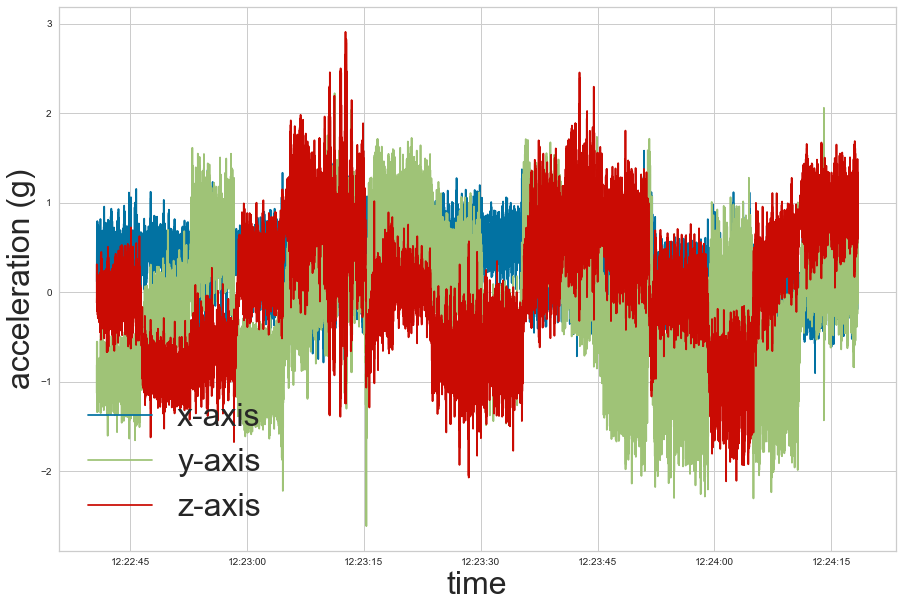

In [9]:
fig=plt.figure(figsize=(15,10))
ax=fig.add_subplot()

y = df[["x-axis (g)", "y-axis (g)", "z-axis (g)"]]#[1675:2000]
x = df.index#[1675:2000]
ax.plot(x,y["x-axis (g)"], label="x-axis")
ax.plot(x,y["y-axis (g)"], label="y-axis")
ax.plot(x,y["z-axis (g)"], label="z-axis")
ax.set_xlabel("time", fontsize=32)
ax.set_ylabel("acceleration (g)", fontsize=32)
ax.legend(loc="lower left", fontsize=32)
plt.savefig("acc.pdf", bbox_inches='tight')

Examine the power spectral density of accleration (x-axis)

Text(0, 0.5, 'PSD\\ [g$^2$/{Hz}]')

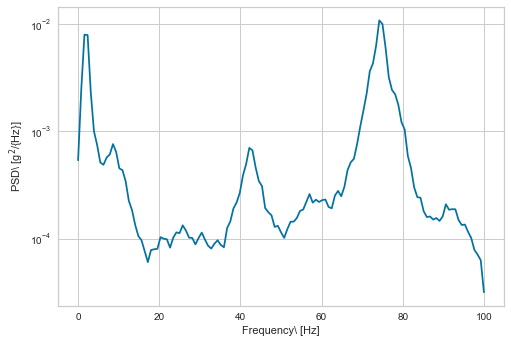

In [10]:
sig = df.loc[:,"x-axis (g)"]
f, Pxx = signal.welch(sig, fs)

fig,ax = plt.subplots(1)
ax.semilogy(f, Pxx)
ax.set_xlabel(r'Frequency\ [Hz]')
ax.set_ylabel(r'PSD\ [g$^2$/{Hz}]')

In order to remove the motor noise we define various filters - band pass and low pass

In [11]:
def bpf(x, lowcut, highcut, order, fs):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = signal.butter(order, [low, high], btype='band')
    x = signal.lfilter(b, a, x, axis=0)
    return x

def lpf(x, highcut, order, fs):
    nyq = 0.5 * fs
    high = highcut / nyq
    b, a = signal.butter(order, high, btype='low')
    x = signal.lfilter(b, a, x, axis=0)
    return x


A 2Hz low-pass filter removes most of the noise, leaving only the brush stroke on the x-axis.

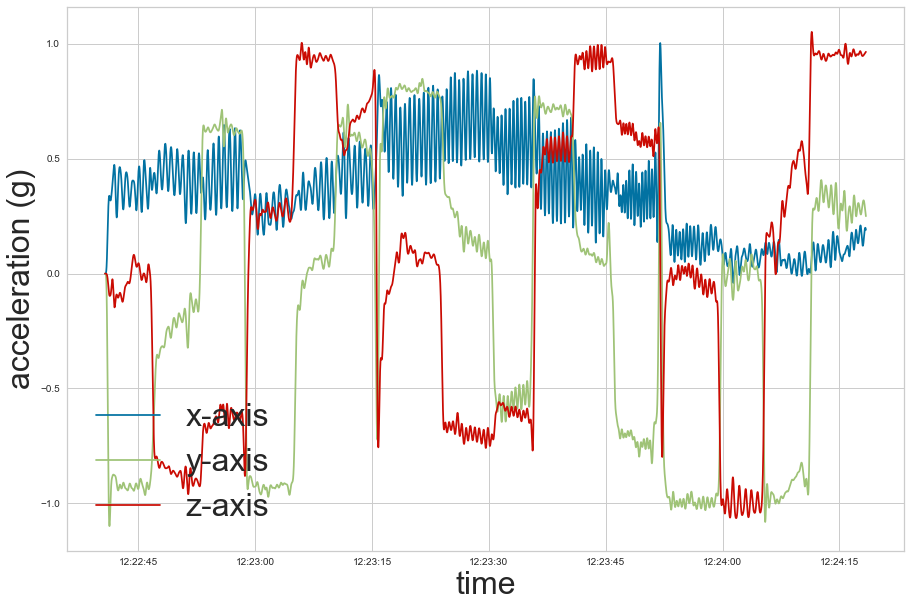

In [12]:
fig=plt.figure(figsize=(15,10))
ax=fig.add_subplot()

df["lpf__x-axis (g)"] = lpf(df["x-axis (g)"], 2.0, 6, fs)
df["lpf__y-axis (g)"] = lpf(df["y-axis (g)"], 2.0, 6, fs)
df["lpf__z-axis (g)"] = lpf(df["z-axis (g)"], 2.0, 6, fs)

y = df[["lpf__x-axis (g)", "lpf__y-axis (g)", "lpf__z-axis (g)"]]#[1675:2000]
x = df.index#[1675:2000]
ax.plot(x,y["lpf__x-axis (g)"], label="x-axis")
ax.plot(x,y["lpf__y-axis (g)"], label="y-axis")
ax.plot(x,y["lpf__z-axis (g)"], label="z-axis")
ax.set_xlabel("time", fontsize=32)
ax.set_ylabel("acceleration (g)", fontsize=32)
ax.legend(loc="lower left", fontsize=32)
plt.savefig("acc-filt.pdf", bbox_inches='tight')

If we plot the filtered acceleration in 3D, we can clearly see clusters from each activity.

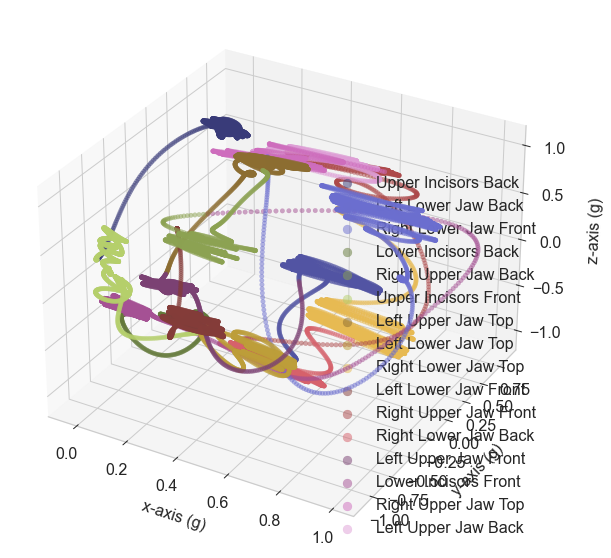

In [17]:
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.cm as mplcm
import matplotlib.colors as colors

df["lpf__x-axis (g)"] = lpf(df["x-axis (g)"], 2.0, 6, fs)
df["lpf__y-axis (g)"] = lpf(df["y-axis (g)"], 2.0, 6, fs)
df["lpf__z-axis (g)"] = lpf(df["z-axis (g)"], 2.0, 6, fs)

x = df[["lpf__x-axis (g)", "lpf__y-axis (g)", "lpf__z-axis (g)"]].values

cm = plt.get_cmap('tab20b')
cNorm  = colors.Normalize(vmin=0, vmax=15)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)

fig=plt.figure(figsize=(15,10))
ax=fig.add_subplot(111, projection='3d')
ax.set_prop_cycle(color=[scalarMap.to_rgba(i) for i in range(16)])
for i, label in enumerate(set(labels)):
    mask = df['label']==label
    ax.scatter(xs=x[mask,0], ys=x[mask,1], zs=x[mask,2], zdir='z', label=label, alpha=0.5)
l = ax.legend(markerscale=2., fontsize=16,)

ax.set_xlabel("x-axis (g)", fontsize=16)
ax.set_ylabel("y-axis (g)", fontsize=16)
ax.set_zlabel("z-axis (g)", fontsize=16)
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=8)

ax.tick_params(axis='z', which='major', pad=10)

ax.xaxis.labelpad=15
ax.yaxis.labelpad=15
ax.zaxis.labelpad=25



Since the gyroscope measure angular velocity it tends to spike when the user rolls the brush and then reverts to zero.

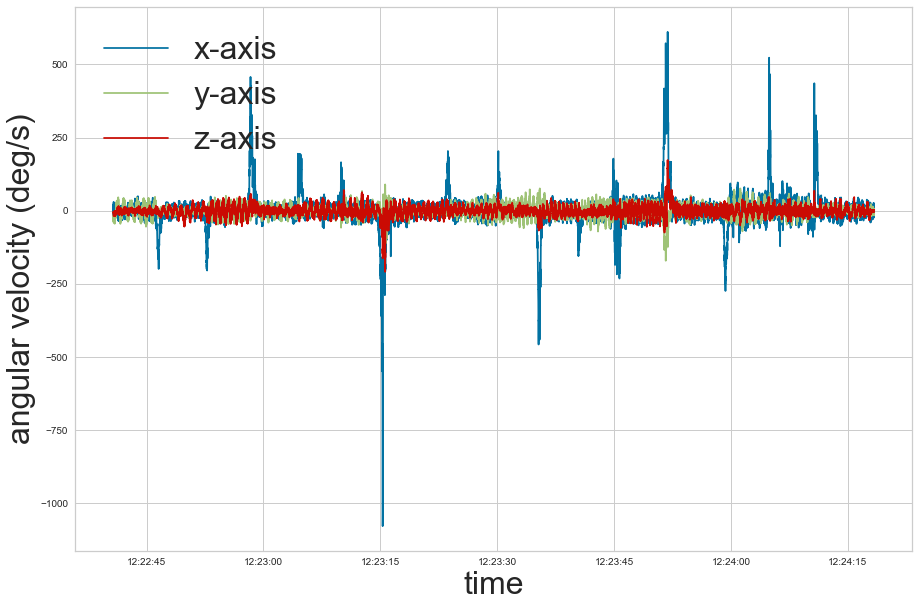

In [18]:
fig=plt.figure(figsize=(15,10))
ax=fig.add_subplot()

y = df[["x-axis (deg/s)", "y-axis (deg/s)", "z-axis (deg/s)"]]
x = df.index
ax.plot(x,y["x-axis (deg/s)"], label="x-axis")
ax.plot(x,y["y-axis (deg/s)"], label="y-axis")
ax.plot(x,y["z-axis (deg/s)"], label="z-axis")
ax.set_xlabel("time", fontsize=32)
ax.set_ylabel("angular velocity (deg/s)", fontsize=32)
ax.legend(loc="upper left", fontsize=32)
plt.savefig("angular-velocity.pdf", bbox_inches='tight')

The integral of angualr velocity is the angle. Integration causes drift and Kalman filters or Complimentary filters are more accurate but a simple integral provides more information than the angular velocity itself.

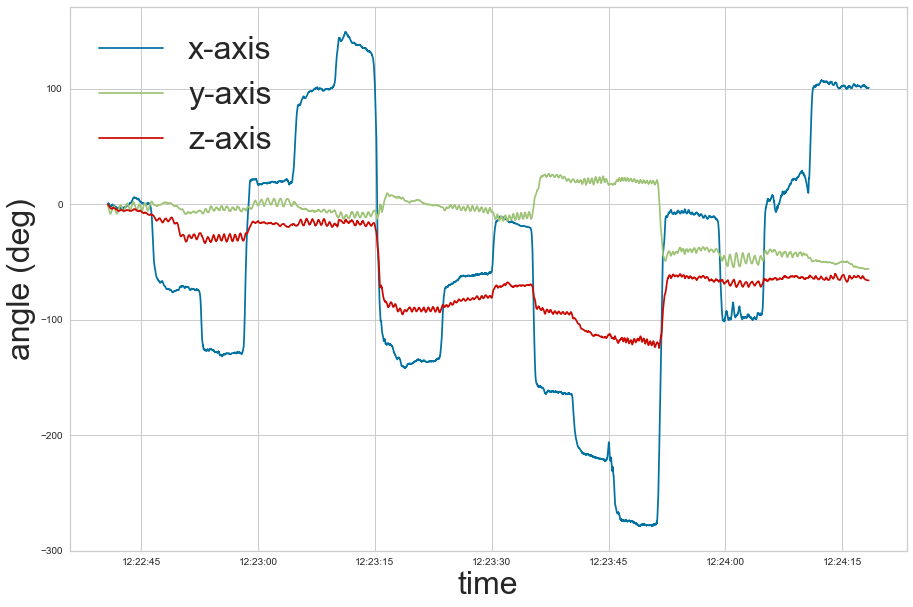

In [19]:
fig=plt.figure(figsize=(15,10))
ax=fig.add_subplot()

y = df[["x-axis (deg/s)", "y-axis (deg/s)", "z-axis (deg/s)"]]
x = df.index
ax.plot(x,y["x-axis (deg/s)"].cumsum() / 200.0, label="x-axis")
ax.plot(x,y["y-axis (deg/s)"].cumsum() / 200.0, label="y-axis")
ax.plot(x,y["z-axis (deg/s)"].cumsum() / 200.0, label="z-axis")
ax.set_xlabel("time", fontsize=32)
ax.set_ylabel("angle (deg)", fontsize=32)
ax.legend(loc="upper left", fontsize=32)
plt.savefig("angle.pdf", bbox_inches='tight')

The following code implements a 'complimentary filter' to obtain a more robust (drift free) estimate of the roll and pitch angle

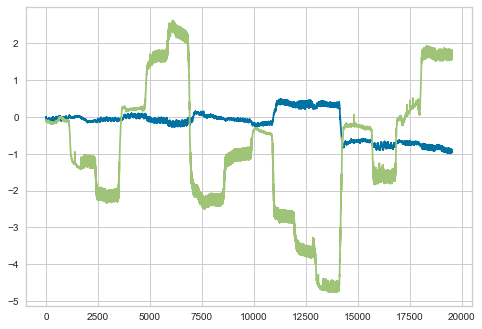

In [20]:
c=0.95 # filter time constant - usually 0.95-0.98

# compute angles from gyroscope
gyro = df[["x-axis (deg/s)", "y-axis (deg/s)", "z-axis (deg/s)"]].values
gyro = np.radians(gyro)
angles = np.cumsum(gyro, axis=0) / fs

# remove gravity from accel - low pass filter to (approximately) separate linear acceleration from gravity
accel = df[["x-axis (g)", "y-axis (g)", "z-axis (g)"]].values

g = accel[0,:]
alpha=0.8
gravity=np.zeros(angles.shape)
for i in range(len(angles)):
    g = 0.8 * g + (1-alpha) * accel[i,:]
    gravity[i,:] = g

accel = accel - g

# apply complimentary filter - combines integrated gyro pitch / roll and same angles calculated from linear accelerations
attitudes=np.zeros((angles.shape[0],2))
for i in range(len(attitudes)):
    # https://www.nxp.com/files-static/sensors/doc/app_note/AN3461.pdf
    roll=angles[i,0]
    accel_roll = np.arctan2(accel[i,1], accel[i,2])
    roll=c*roll+(1-c)*accel_roll

    pitch=angles[i,1]
    accel_pitch = np.arctan2(-accel[i,0], np.sqrt(accel[i,1]*accel[i,1] + accel[i,2]*accel[i,2]))
    pitch=c*pitch+(1-c)*accel_pitch

    attitudes[i,:] = np.array([pitch,roll])
df['pitch'] = attitudes[:,0]
df['roll'] = attitudes[:,1]

plt.plot(attitudes)

Finally we rrain a simple SVC classifier

In [21]:


data, labels = load_dataset(PATH, experiment, device)
df = pd.concat([data,labels], axis=1)
df["lpf__x-axis (g)"] = lpf(df["x-axis (g)"], 2.0, 6, fs)
df["lpf__y-axis (g)"] = lpf(df["y-axis (g)"], 2.0, 6, fs)
df["lpf__z-axis (g)"] = lpf(df["z-axis (g)"], 2.0, 6, fs)

df["angle__x-axis (deg)"] = y["x-axis (deg/s)"].cumsum() / 200.0
df["angle__y-axis (deg)"] = y["y-axis (deg/s)"].cumsum() / 200.0
df["angle__z-axis (deg)"] = y["z-axis (deg/s)"].cumsum() / 200.0

x = df[["lpf__x-axis (g)", "lpf__y-axis (g)", "lpf__z-axis (g)",
        "angle__x-axis (deg)", "angle__x-axis (deg)", "angle__x-axis (deg)"]].values
y = df['label'].map({
        "Left Lower Jaw Front":1,
        "Left Lower Jaw Top":2,
        "Left Lower Jaw Back":3,
        "Left Upper Jaw Front":4,
        "Left Upper Jaw Top":5,
        "Left Upper Jaw Back":6,
        "Right Lower Jaw Front":7,
        "Right Lower Jaw Top":8,
        "Right Lower Jaw Back":9,
        "Right Upper Jaw Front":10,
        "Right Upper Jaw Top":11,
        "Right Upper Jaw Back":12,
        "Lower Incisors Front":13,
        "Lower Incisors Back":14,
        "Upper Incisors Front":15,
        "Upper Incisors Back":16
    })

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(x_train, y_train)

print(f'train accuracy: {100*clf.score(x_train, y_train):.2f}%')
print(f'test accuracy: {100*clf.score(x_test, y_test):.2f}%')

train accuracy: 98.61%
test accuracy: 98.51%


<AxesSubplot:title={'center':'SVC Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

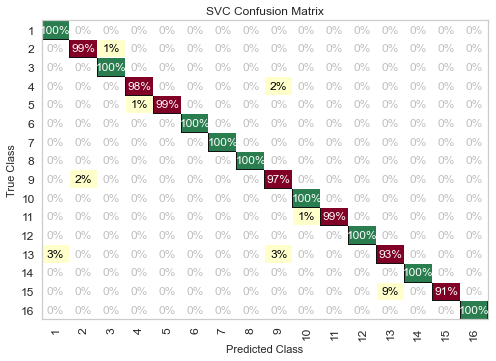

In [22]:
from yellowbrick.classifier import ConfusionMatrix

cm = ConfusionMatrix(clf, percent=True).fit(x_train, y_train)
cm.score(x_test, y_test)
cm.show(outpath="confusion.pdf")